In [1]:
import gym
from gym import spaces
from gym.utils import seeding
from collections import defaultdict
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
env = gym.make('Blackjack-v0')
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


### Оценим с помощью first-visit Монте-Карло выиграш от rule-based стратегии, говорим stand если сумма на руках больше 18, иначе - говорим hit.

In [3]:
def defined_policy(state):
    score, _, _ = state
    return 0 if score > 18 else 1

def generate_episode(env, policy):
    episode = []
    state = env.reset()
    while True:
        action = policy(state)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [4]:
def first_visit_mc_prediction(policy, env, n_episodes):
    value_table = defaultdict(float)
    N = defaultdict(int)
    cum_reward = []
    for _ in range(n_episodes):
        episode = generate_episode(env, policy)
        cum_reward.append(episode[-1][-1])
        returns = 0
        for t in range(len(episode) - 1, -1, -1):
            R = episode[t][2]
            S = episode[t][0]
            returns += R
            if S not in [x[0] for x in episode[:t]]:
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]
    return value_table, cum_reward

In [5]:
value, cum_reward = first_visit_mc_prediction(defined_policy, env, n_episodes = 500000)
for i in range(10):
    print(value.popitem())

((5, 3, False), -0.38025210084033634)
((4, 2, False), -0.2760180995475113)
((12, 5, True), -0.14716981132075466)
((4, 7, False), -0.3403361344537814)
((5, 5, False), -0.37179487179487214)
((13, 6, True), -0.07096774193548389)
((16, 4, True), -0.23302469135802484)
((4, 6, False), -0.2914798206278027)
((13, 7, True), -0.08528784648187634)
((12, 6, True), -0.016949152542372902)


In [55]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)         
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V.get((player, dealer, ace), 0)
    X, Y = np.meshgrid(player_sum, dealer_show)
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])   
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
    for ax in ax1, ax2:    
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer sum')
        ax.set_zlabel('state-value')

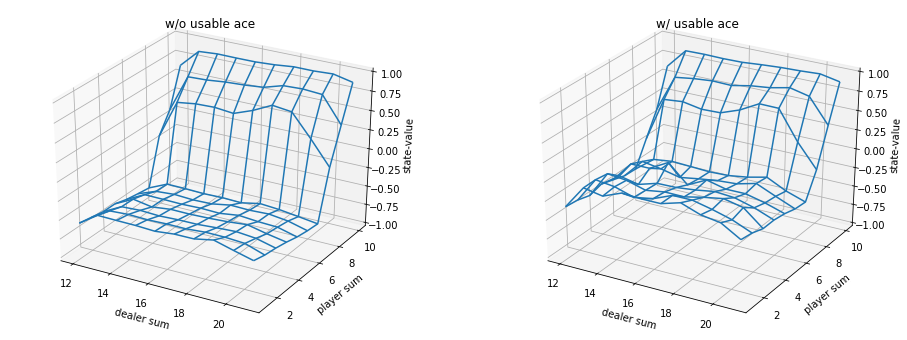

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6),subplot_kw={'projection': '3d'})
axes[0].set_title('w/o usable ace')
axes[1].set_title('w/ usable ace')
plot_blackjack(value, axes[0], axes[1])

In [ ]:
plt.figure(figsize = (10, 6))
plt.title('Cumulative reward')
plt.plot(np.cumsum(cum_reward))
plt.show()

### Теперь реализуем метод обучения с подкреплением Monte-Carlo control.

In [8]:
# возвращаем вероятность лучшего действия согласно epsilon
def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

# обновляем Q
def update_Q(env, episode, Q, alpha, gamma):
    for s, a, r in episode:
        first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
        Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])
    return Q

# policy
def mc_control_policy(Q, state, epsilon, nA):
    if state in Q:
        return np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA))
    else:
        return None
    
# новый генератор эпизодов
def generate_episode_from_Q(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:
        
        action = mc_control_policy(Q, state, epsilon, nA)
        if action is None:
            action = env.action_space.sample()
            
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [9]:
# Monte-Carlo control
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99995, eps_min=0.01):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    cum_reward = []
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        epsilon = max(epsilon*eps_decay, eps_min)
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        cum_reward.append(episode[-1][-1])
        Q = update_Q(env, episode, Q, alpha, gamma)
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, cum_reward

In [39]:
policy, Q, cum_reward = mc_control(env, num_episodes = 1000000, alpha = 0.015, 
                                   gamma=1.0, eps_start=1.0, eps_decay=.99995, eps_min=0.01)

Episode 1000000/1000000.

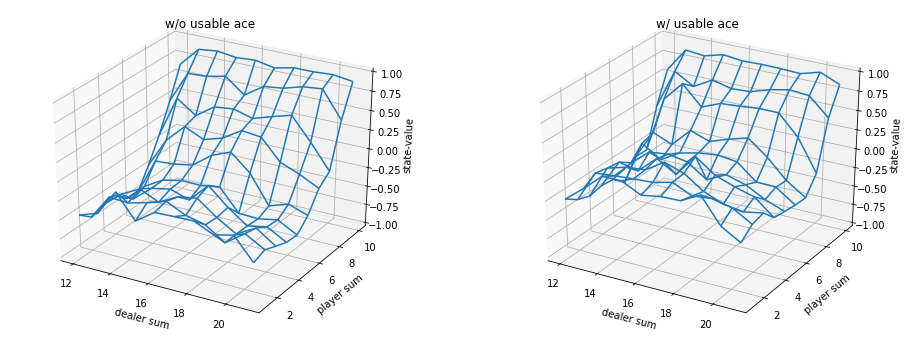

In [40]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6),subplot_kw={'projection': '3d'})
axes[0].set_title('w/o usable ace')
axes[1].set_title('w/ usable ace')
plot_blackjack({k: max(v) for k, v in Q.items()}, axes[0], axes[1])

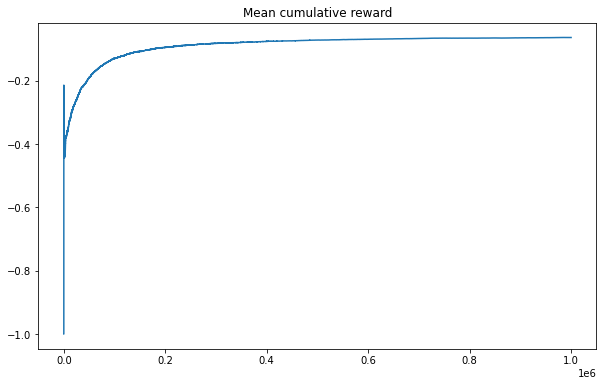

array([-0.06388626, -0.06388719, -0.06388613, -0.06388506, -0.063886  ])

In [42]:
plt.figure(figsize = (10, 6))
plt.title('Mean cumulative reward')
plt.plot(np.cumsum(cum_reward) / np.arange(1, 1000001) )
plt.show()
(np.cumsum(cum_reward) / np.arange(1, 1000001))[-5:]

In [23]:
from blackjack_double import BlackjackEnv

In [43]:
env2 = BlackjackEnv()

In [44]:
print(env2.observation_space)
print(env2.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(3)


In [45]:
policy, Q, cum_reward = mc_control(env2, num_episodes = 1000000, alpha = 0.015, 
                                   gamma=1.0, eps_start=1.0, eps_decay=.99995, eps_min=0.01)

Episode 1000000/1000000.

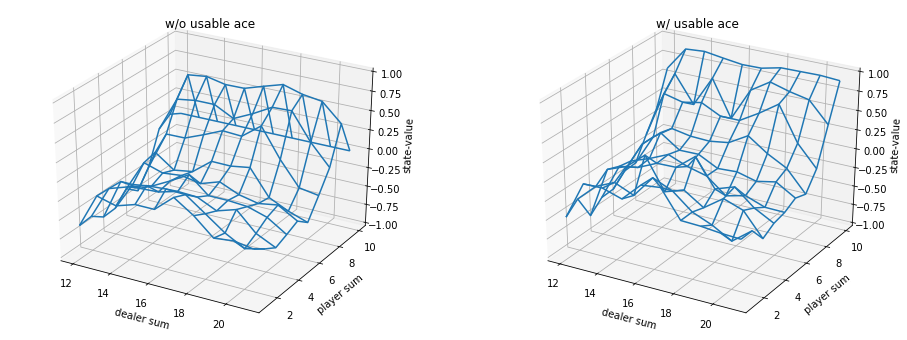

In [56]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6),subplot_kw={'projection': '3d'})
axes[0].set_title('w/o usable ace')
axes[1].set_title('w/ usable ace')
plot_blackjack({k: max(v) for k, v in Q.items()}, axes[0], axes[1])

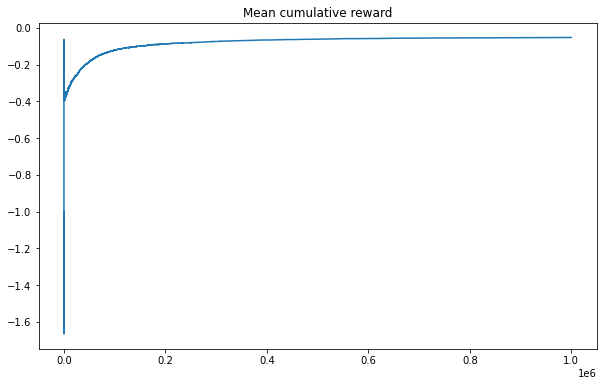

array([-0.05241221, -0.05241116, -0.0524101 , -0.05241105, -0.052412  ])

In [54]:
plt.figure(figsize = (10, 6))
plt.title('Mean cumulative reward')
plt.plot(np.cumsum(cum_reward) / np.arange(1, 1000001) )
plt.show()
(np.cumsum(cum_reward) / np.arange(1, 1000001))[-5:]